# Transformer recipe generator training

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the recipe dataset.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatib

Import modules and set random seeds.

In [2]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Vocabulary size: 30522


Download the recipe dataset and extract directions texts.

In [4]:
from datasets import load_dataset
recipe = load_dataset('Shengtao/recipe')

def join_title_and_directions(title_directions):
    title, directions = title_directions
    return 'Recipe for {}: {}'.format(title, directions)

recipe_texts = list(map(join_title_and_directions,
                        zip(recipe['train']['title'], recipe['train']['directions'])))
recipe_texts = recipe_texts[::4] # Select 25% of the entire training set.

Generating train split:   0%|          | 0/32722 [00:00<?, ? examples/s]

Check the distribuion of the text length.

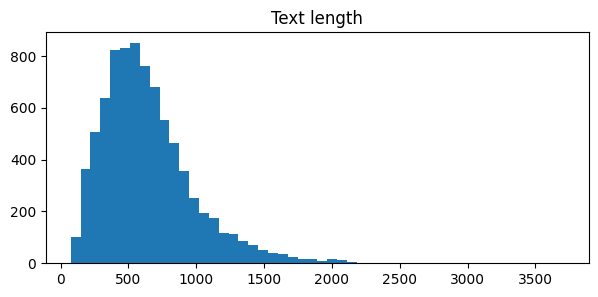

In [5]:
fig = plt.figure(figsize=(7, 3))
subplot = fig.add_subplot(1,1,1)
subplot.set_title('Text length')
_ = subplot.hist(list(map(lambda x: len(x), recipe_texts)), bins=50)

Create the training and test datasets, truncating long texts into 512 words.

In [6]:
MAX_LEN = 512

train_set, test_set = train_test_split(recipe_texts, test_size=0.1)

train_set = tokenizer(train_set, max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])[:, :-1]
train_label = np.array(train_set['input_ids'])[:, 1:]

test_set = tokenizer(test_set, max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])[:, :-1]
test_label = np.array(test_set['input_ids'])[:, 1:]

Define the positional embedding layer.

In [7]:
class Embeddings(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(Embeddings, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=max_len,
                                        output_dim=embed_dim)
        self.dropout = layers.Dropout(rate=0.5)
        self.ln = layers.LayerNormalization(epsilon=1e-12)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)

        token_embeddings = self.token_emb(inputs)
        embeddings = token_embeddings + position_embeddings # Add positional embeddings

        embeddings = self.ln(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

Dfiner the Transformer encoder block.

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(rate=0.1)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(rate=0.1)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        causal_mask = self.causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        attention_output =  attention_output + inputs # Skip connection
        attention_output = self.ln_1(attention_output)

        ffn_1 = self.ffn_1(attention_output)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)

        ffn_output = ffn_output + attention_output # Skip connection
        ffn_output = self.ln_2(ffn_output)
        return (ffn_output, attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
            }
        )
        return config

Define the Transformer model consisted of a single Transformer encoder blocks.

In [9]:
EMBEDDING_DIM = 512
N_HEADS = 8
KEY_DIM = EMBEDDING_DIM // N_HEADS
FEED_FORWARD_DIM = 2048

text_inputs = layers.Input(shape=(None,), dtype=tf.int32)

x = Embeddings(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(text_inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x)
output = layers.Dense(VOCAB_SIZE, activation='softmax')(x)

# Model for training and prediction
transformer_model = models.Model(
    inputs=text_inputs, outputs=output)

# Model for inference including attention scores
attention_scores_model = models.Model(
    inputs=text_inputs,
    outputs=[output, attention_scores])

transformer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embeddings (Embeddings)     (None, None, 512)         15890432  
                                                                 
 transformer_block (Transfo  ((None, None, 512),       3152384   
 rmerBlock)                   (None, 8, None, None))             
                                                                 
 dense_2 (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 34700602 (132.37 MB)
Trainable params: 34700602 (132.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model using the Adam optimizer, and the sparse categorical crossentroy as a loss function.

In [10]:
transformer_model.compile('adam',
                          loss=losses.SparseCategoricalCrossentropy(),
                          metrics=['acc'])

Train the model.

In [11]:
%%time
history = transformer_model.fit(train_text, train_label,
                                validation_data=(test_text, test_label),
                                batch_size=8, epochs=5)

Epoch 1/5
921/921 [==============================] - 234s 247ms/step - loss: 1.1090 - acc: 0.7985 - val_loss: 0.8771 - val_acc: 0.8222
Epoch 2/5
921/921 [==============================] - 217s 235ms/step - loss: 0.8268 - acc: 0.8261 - val_loss: 0.7794 - val_acc: 0.8370
Epoch 3/5
921/921 [==============================] - 224s 243ms/step - loss: 0.7472 - acc: 0.8378 - val_loss: 0.7205 - val_acc: 0.8474
Epoch 4/5
921/921 [==============================] - 216s 235ms/step - loss: 0.6913 - acc: 0.8464 - val_loss: 0.6864 - val_acc: 0.8535
Epoch 5/5
921/921 [==============================] - 224s 243ms/step - loss: 0.6529 - acc: 0.8519 - val_loss: 0.6641 - val_acc: 0.8568
CPU times: user 8min 45s, sys: 21.9 s, total: 9min 7s
Wall time: 18min 35s


Mount the google drive and save the trained model.

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

transformer_model.save('/content/gdrive/My Drive/Transformer_recipe_generator')
attention_scores_model.save('/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores')

Mounted at /content/gdrive


In [14]:
!ls -lhR '/content/gdrive/My Drive/Transformer_recipe_generator'
!ls -lhR '/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores'

'/content/gdrive/My Drive/Transformer_recipe_generator':
total 493K
drwx------ 2 root root 4.0K Jul  4  2023 assets
-rw------- 1 root root   56 Jun 17 07:36 fingerprint.pb
-rw------- 1 root root  22K Jun 17 07:36 keras_metadata.pb
-rw------- 1 root root 462K Jun 17 07:36 saved_model.pb
drwx------ 2 root root 4.0K Jun 17 07:36 variables

'/content/gdrive/My Drive/Transformer_recipe_generator/assets':
total 0

'/content/gdrive/My Drive/Transformer_recipe_generator/variables':
total 398M
-rw------- 1 root root 398M Jun 17 07:36 variables.data-00000-of-00001
-rw------- 1 root root 4.4K Jun 17 07:36 variables.index
'/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores':
total 359K
drwx------ 2 root root 4.0K Jul  4  2023 assets
-rw------- 1 root root   57 Jun 17 07:36 fingerprint.pb
-rw------- 1 root root  21K Jun 17 07:36 keras_metadata.pb
-rw------- 1 root root 330K Jun 17 07:36 saved_model.pb
drwx------ 2 root root 4.0K Jun 17 07:36 variables

'/content/gdrive/My Drive/